In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.fftpack import fft
from scipy.signal import find_peaks, hilbert
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt
# Define the FitzHugh-Nagumo model equations
def fitzhugh_nagumo_coupled(t, xy,alpha , w2, a, b, c, k1, k2):
    x, y , x1, y1= xy
    dxdt = alpha*(y + x - (x**3)/3 + (k1 + c*x1))
    dydt = -(1/alpha) * (w2*x - a + b*y)
    dx1dt = alpha*(y1 + x1 - (x1**3)/3 + (k2 + c*x))
    dy1dt = -(1/alpha) * (w2*x1 - a + b*y1)
    return [dxdt, dydt, dx1dt, dy1dt]

# Define events
# def R_idx(s1,s2):
#     h1 = hilbert(s1)
#     h2 = hilbert(s2)
#     p1 = np.angle(h1)
#     p2 = np.angle(h2)
#     p_diff = p1-p2
#     R = np.abs(np.mean(np.exp(1j*p_diff)))
#     return R
    
def R_idx(s1, s2):
    #use the Morlet wavelet
    wavelet = "cmor1.5-1.0"
    scales = np.arange(1,40) #range of scales
    coi = [2,39] # cone of influence

    #compute the cwt
    cwt_s1, freq_s1 = pywt.cwt(s1, scales, wavelet, sampling_period=40)
    cwt_s2, freq_s2 = pywt.cwt(s2, scales, wavelet, sampling_period=40)

    #find the phases
    p1 = np.angle(cwt_s1)
    p2 = np.angle(cwt_s2)
    p_diff= p1-p2

    #find the dominating freq of frequency s1
    p_diff = p_diff[np.argmax(np.sum(np.abs(cwt_s1),axis=1)),:]

    R = np.abs(np.mean(np.exp(1j*p_diff)))
    return R

# Define the initial conditions and parameter values
alpha = 3
a = 0.7
b = 0.8
w2 = 1
x0 = 0
y0 = 0
x10 = 0
y10 = 0
xy0=[x0, x10, y0, y10]
c_vals = np.linspace(-0.5,0,num=30)
k1_vals = np.linspace(-0.85,-0.3, num=30)
k2_vals = np.linspace(-0.85,-1.4, num=30)
t_span = [0, 200]
t_eval = np.linspace(0,200,10000)

In [3]:

Rmap = np.zeros((c_vals.shape[0], k1_vals.shape[0]))
for i, c in tqdm(enumerate(c_vals)):
    for j, k2 in enumerate(k2_vals):
        k1 = k1_vals[len(k1_vals)-1-j] 
        sol = solve_ivp(fitzhugh_nagumo_coupled, t_span, xy0, args=(alpha,w2,a,b,c,k1,k2),t_eval=t_eval,dense_output=True,rtol=1e-8)

        s1 = sol.y[0]
        s2 = sol.y[2]
        
        #Apply hamming filter
        window = np.hamming(s1.shape[0])
        s1 = s1 * window 
        s2 = s2 * window
        
        #Calculate R index
        R = R_idx(s1,s2)
        
        #Save to response map
        Rmap[i, j] = R

30it [04:41,  9.38s/it]


In [4]:
Rmap

array([[0.55803654, 0.60344618, 0.64770309, 0.69520032, 0.73376998,
        0.7708746 , 0.80707306, 0.83692955, 0.87390651, 0.90100057,
        0.92831629, 0.94937646, 0.96653385, 0.97838493, 0.98876709,
        0.98545689, 0.98064539, 0.97733276, 0.97364563, 0.96833622,
        0.94960052, 0.93082249, 0.91429835, 0.89092635, 0.86432882,
        0.82769601, 0.79837146, 0.76360075, 0.7265619 , 0.68787079],
       [0.50605488, 0.55575445, 0.60065903, 0.65721331, 0.70130831,
        0.74472609, 0.78894731, 0.82574979, 0.86032989, 0.89191348,
        0.92023208, 0.94382658, 0.9606217 , 0.97252625, 0.9779365 ,
        0.97697291, 0.97825145, 0.9805252 , 0.97473046, 0.95542613,
        0.94355255, 0.92683874, 0.90323032, 0.87566429, 0.84498062,
        0.81132213, 0.77589558, 0.72561629, 0.69119951, 0.64704565],
       [0.44603565, 0.5078304 , 0.56082211, 0.61355768, 0.66447395,
        0.71279162, 0.76253206, 0.80469129, 0.84218868, 0.88265195,
        0.91293842, 0.93595693, 0.95310718, 0.

30it [00:00, 118594.84it/s]


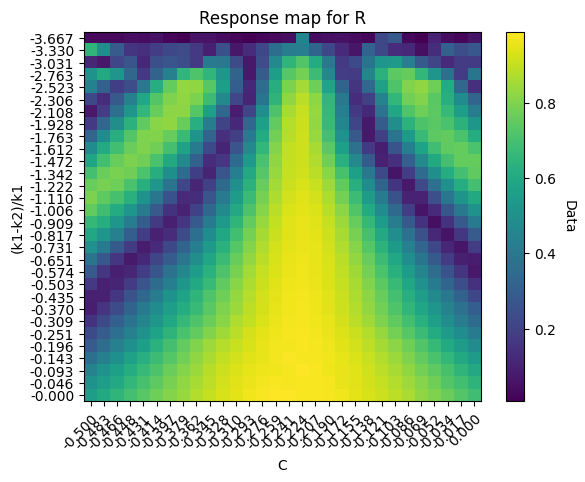

In [5]:
K = []
C = []
for i, c in tqdm(enumerate(c_vals)):
    C.append(c)
for i,_ in enumerate(k2_vals):
    K.append((k1_vals[i]-k2_vals[i])/(k1_vals[i]))
# for k1 in k1_vals:
#     K.append(k1)  

# plt.imshow(Rmap, cmap='viridis', origin='lower', aspect='auto',)
fig, ax = plt.subplots()
im = ax.imshow(Rmap, cmap='viridis', origin='lower', aspect='auto',)

# Set tick labels
ax.set_xticks(np.arange(len(C)))
ax.set_yticks(np.arange(len(K)))
ax.set_xticklabels([f"{c:.3f}" for c in C])
ax.set_yticklabels([f"{k:.3f}" for k in K])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Data', rotation=-90, va="bottom")

# Add axis labels
ax.set_xlabel('C')
ax.set_ylabel('(k1-k2)/k1')
ax.set_title("Response map for R")
# Show plot
plt.show()

In [6]:

k1 = -0.40092
k2 = -1.7-k1
c = -0.207
# k1 = -0.3
# k2 = -0.68
# c = -0.3
sol = solve_ivp(fitzhugh_nagumo_coupled, t_span, xy0, args=(alpha,w2,a,b,c,k1,k2), t_eval=t_eval, dense_output=True,rtol=1e-8)
t = sol.t
s1 = sol.y[0]
s2 = sol.y[2]

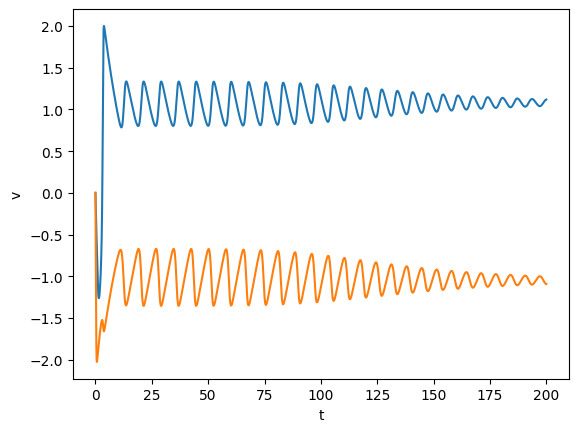

In [7]:
# plt.plot(t[0:100], (np.abs(np.fft.fft(v))**2)[0:100])
plt.plot(t, s1)
plt.plot(t, s2)
plt.xlabel('t')
plt.ylabel('v')
plt.show()